In [81]:
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

In [82]:
# only need to download/install once

nltk.download('popular')  
nltk.download('vader_lexicon')  
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install transformers
!{sys.executable} -m pip install scipy

# 1. Data Extraction

In [83]:
df = pd.read_csv('sentiment_analysis_data_input.csv')
df.info()
print('\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111507 entries, 0 to 111506
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ReviewId       111507 non-null  int64 
 1   RecipeId       111507 non-null  int64 
 2   AuthorId       111507 non-null  int64 
 3   AuthorName     111507 non-null  object
 4   Rating         111507 non-null  int64 
 5   Review         111507 non-null  object
 6   DateSubmitted  111507 non-null  object
 7   DateModified   111506 non-null  object
dtypes: int64(4), object(4)
memory usage: 6.8+ MB




,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


# 2. Data Preprocessing

In [84]:
# check for duplicates

print("Number of entries before dropping duplicates is: ", len(df))
df = df.drop_duplicates() # drop any duplicate entries
print("Number of entries after dropping duplicates is: ", len(df)) # same as number of entries before, so no duplicates

Number of entries before dropping duplicates is:  111507
Number of entries after dropping duplicates is:  111507


In [85]:
# reduce number of entries for running purposes

df = df.head(500) # 111,507 entries takes too long to run, reduce to 500

# 3. Brief Exploratory Data Analysis

In [86]:
# number of reviews for each type of rating

df_ratings = df['Rating'].value_counts().sort_index() # number of times each rating occurs, in order of rating
df_ratings

Rating
0     46
1     23
2     20
3     38
4    123
5    250
Name: count, dtype: int64

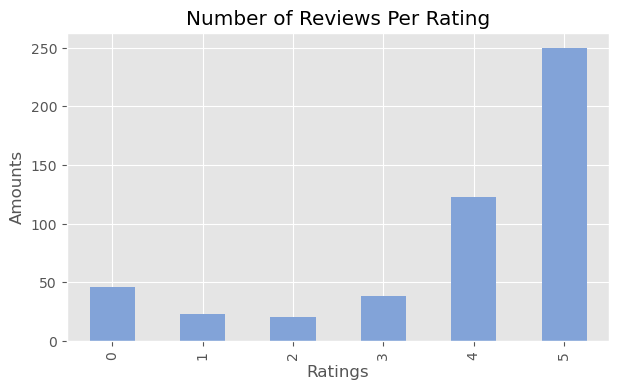

In [87]:
graph_ratings = df_ratings.plot(kind = 'bar', title = 'Number of Reviews Per Rating', figsize = (7, 4), color = '#82A3D8')
graph_ratings.set_xlabel('Ratings') # x axis label
graph_ratings.set_ylabel('Amounts') # y axis label
plt.show() # show the graph

Most of the ratings are 5 stars. There are more 0 star ratings than 1 star, and as the rating increases, the number of reviews associated with that rating generally increases as well.

# 4. Natural Language Toolkit

In [88]:
sample = df['Review'][3] # just take entry at index 3 as an example
print(sample)

easily the best i have ever had.  juicy flavorful, not dry.  the vegetables retain crispness as well, not bland at all!


In [89]:
# tokenize the sample into tokens

tokens = nltk.word_tokenize(sample)
print(tokens)

['easily', 'the', 'best', 'i', 'have', 'ever', 'had', '.', 'juicy', 'flavorful', ',', 'not', 'dry', '.', 'the', 'vegetables', 'retain', 'crispness', 'as', 'well', ',', 'not', 'bland', 'at', 'all', '!']


In [90]:
# get the part of speech for each token

tags = nltk.pos_tag(tokens)
print(tags)

[('easily', 'RB'), ('the', 'DT'), ('best', 'JJS'), ('i', 'NN'), ('have', 'VBP'), ('ever', 'RB'), ('had', 'VBN'), ('.', '.'), ('juicy', 'NN'), ('flavorful', 'NN'), (',', ','), ('not', 'RB'), ('dry', 'JJ'), ('.', '.'), ('the', 'DT'), ('vegetables', 'NNS'), ('retain', 'VBP'), ('crispness', 'NN'), ('as', 'RB'), ('well', 'RB'), (',', ','), ('not', 'RB'), ('bland', 'VB'), ('at', 'IN'), ('all', 'DT'), ('!', '.')]


From above, 'easily' is RB, which corresponds to an adverb. Full list of meanings of part of speech abbreviations found at https://www.guru99.com/pos-tagging-chunking-nltk.html

In [91]:
# takes tokens and groups into chunks of texts

chunks = nltk.chunk.ne_chunk(tags)
chunks.pprint()

(S
  easily/RB
  the/DT
  best/JJS
  i/NN
  have/VBP
  ever/RB
  had/VBN
  ./.
  juicy/NN
  flavorful/NN
  ,/,
  not/RB
  dry/JJ
  ./.
  the/DT
  vegetables/NNS
  retain/VBP
  crispness/NN
  as/RB
  well/RB
  ,/,
  not/RB
  bland/VB
  at/IN
  all/DT
  !/.)


# 5. Sentiment Analysis Using VADER

VADER: Valence Aware Dictionary and Sentiment Reasoner <br> 
Approach: 
- Removes stop words, which are words like "the" which have no meaning
- Has a positive/neutral/negative value for each word in the sentence 
- Takes the values for all the words in the sentence and combines them to identify how positive/neutral/negative the overall sentence is <br>


Note: VADER is weaker than RoBERTa, as it does not consider the relationships between words, and just evaluates them individually

## 5.1 VADER Analysis

In [92]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # progress tracker for loops

sia = SentimentIntensityAnalyzer() # create the sentiment intensity analyzer object
# using sia, we can calculate polarity score for each of the reviews
# polarity score in [-1, 1] with -1 being negative and 1 being positive sentiment

In [93]:
# VADER model - example of polarity score of the review for one entry in df

print(sample)
sia.polarity_scores(sample) 

easily the best i have ever had.  juicy flavorful, not dry.  the vegetables retain crispness as well, not bland at all!


{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.8398}

In [94]:
# VADER model - run polarity score on the reviews for all entries in df

vader_scores = {} # used to store the polarity score

for entry, row in tqdm(df.iterrows(), total = len(df)): # for each entry in dataframe
    current_id = row['ReviewId'] # store the review ID
    review = row['Review'] # store the review
    review_polarity_score = sia.polarity_scores(review) # calculate polarity score of review
    vader_scores[current_id] = review_polarity_score # store polarity score in scores dictionary at index current_id

  0%|          | 0/500 [00:00<?, ?it/s]

In [95]:
# now we have positive/neutral/negative score and compound score for all reviews using VADER model

vader = pd.DataFrame(vader_scores).T # T to transpose, so index is the row and pos/neu/neg are columns
vader

,neg,neu,pos,compound
2,0.000,0.687,0.313,0.4926
7,0.100,0.900,0.000,-0.2732
9,0.205,0.795,0.000,-0.4767
13,0.000,0.654,0.346,0.8398
14,0.000,0.351,0.649,0.5719
...,...,...,...,...
715,0.000,0.831,0.169,0.6705
716,0.066,0.741,0.193,0.5859
718,0.000,0.734,0.266,0.7832
722,0.000,0.524,0.476,0.8979


In [96]:
# reset the index, and original index now becomes column titled ReviewId

vader = vader.reset_index().rename(columns = {'index': 'ReviewId'})
vader.head()

,ReviewId,neg,neu,pos,compound
0,2,0.000,0.687,0.313,0.4926
1,7,0.100,0.900,0.000,-0.2732
2,9,0.205,0.795,0.000,-0.4767
3,13,0.000,0.654,0.346,0.8398
4,14,0.000,0.351,0.649,0.5719


In [97]:
display(df.head())

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [98]:
# merge vader table with dataframe on the ReviewId column, and store in vader

vader = vader.merge(df, on = 'ReviewId', how = 'left')
vader.rename(columns={'neg': 'vader_neg', 'neu': 'vader_neu', 'pos': 'vader_pos', 'compound' : 'vader_compound'}, inplace=True)
vader

,ReviewId,vader_neg,vader_neu,vader_pos,vader_compound,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,0.000,0.687,0.313,0.4926,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,0.100,0.900,0.000,-0.2732,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,0.205,0.795,0.000,-0.4767,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,0.000,0.654,0.346,0.8398,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,0.000,0.351,0.649,0.5719,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...
495,715,0.000,0.831,0.169,0.6705,4978,8511,Tod Monet,2,This dish might have tasted better by either r...,2001-04-19T11:13:16Z,2001-04-19T11:13:16Z
496,716,0.066,0.741,0.193,0.5859,7805,8512,Betty Sanders,0,I like the idea haveing the nuturtional value ...,2001-04-19T11:13:16Z,2001-04-19T11:13:16Z
497,718,0.000,0.734,0.266,0.7832,2086,3934,Sandy,5,This is wonderful. I made one batch for trial ...,2001-04-22T19:54:35Z,2001-04-22T19:54:35Z
498,722,0.000,0.524,0.476,0.8979,4785,8556,debbie ellison,5,"GREAT RECIPES,\r\nMY FATHER IS A FICKLE EATER,...",2001-04-22T19:54:36Z,2001-04-22T19:54:36Z


## 5.2 VADER Graph

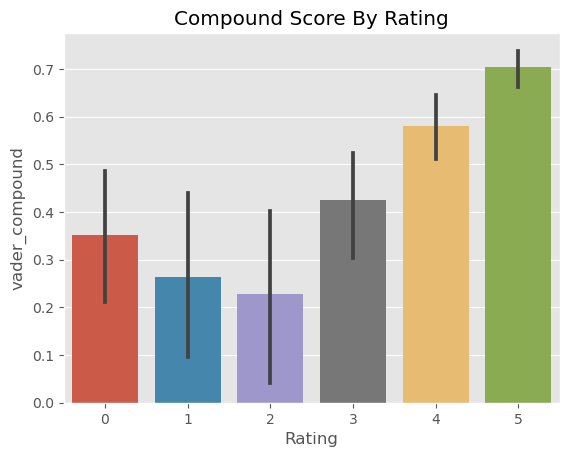

In [99]:
vader_graph = sns.barplot(data = vader, x = 'Rating', y = 'vader_compound')
vader_graph.set_title('Compound Score By Rating')
plt.show()

## 5.3 VADER Remarks

We would expect that reviews with a higher rating would have a higher positive sentiment, and reviews with a lower rating would have lower sentiment. In general, the VADER analysis reflects this, with higher ratings having a higher compound score, and lower ratings having a lower compound score. 

However, there are some reviews which, for example, have a high rating but not a high compound score. The first entry, for example, has a review of "better than any you can get at a restaurant!" and a rating of 5, however has a positivity score of 0.313 and a compound score of 0.4926, which is lower than what would intuitively be expected. This shows the limitations of the VADER model. VADER looks at the sentiment of the individual words, but not at the relationships between words, which can cause the compound score to be different than what is expected from the review and rating.

# 6. RoBERTa Model

RoBERTa: Robustly Optimized BERT Pretraining Approach
BERT: Bidirectional Encoder Representations from Transformers
Approach:

- Deep learning model that picks up context
- The model is pretrained based on large collections of data to understand the words as well as the relationships and meaning

Note: RoBERTa considers the relationships between words and the context

In [100]:
from transformers import AutoTokenizer # will tokenize similar to nltk
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax # to apply to outputs

In [101]:
# use model that has been pretrained for sentiment analysis

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [102]:
print(sample)

easily the best i have ever had.  juicy flavorful, not dry.  the vegetables retain crispness as well, not bland at all!


In [103]:
# RoBERTa model - example of polarity score of the review for one entry in df

sample_encoding = tokenizer(sample, return_tensors = 'pt') # takes sample and puts it into 1's and 0's embeddings; pt for PyTorch
sample_result = model(**sample_encoding) # apply the model to the tokens
display(sample_result) # stores result in tensor 
sample_score = sample_result[0][0].detach().numpy() # take the first (and only) row of the tensor, remove from PyTorch, and convert to NumPy array
display(sample_score)
sample_score = softmax(sample_score) # transform each logit to a probability, so probabilities sum to 1
sample_score 

SequenceClassifierOutput(loss=None, logits=tensor([[-2.3824, -0.5536,  3.6893]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

array([-2.3824258, -0.5536123,  3.6892943], dtype=float32)

array([0.00226936, 0.01413018, 0.98360044], dtype=float32)

In [104]:
# RoBERTa model - run polarity score on the reviews for all entries in df

roberta_scores = {} # used to store the polarity score

for entry, row in tqdm(df.iterrows(), total = len(df)): # for each entry in dataframe
    
    try: 
        # calculate polarity scores using roberta model
        review = row['Review'] # store the review
        review_encoding = tokenizer(review, return_tensors = 'pt') # takes review and puts it into 1's and 0's embeddings; pt for PyTorch
        review_result = model(**review_encoding) # apply the model to the tokens
        review_score = review_result[0][0].detach().numpy() # take the first (and only) row of the tensor, remove from PyTorch, and convert to NumPy array
        review_score = softmax(review_score) # transform each logit to a probability, so probabilities sum to 1
        review_dict = { # store the scores for the review in a dictionary
            'roberta_neg' : review_score[0],
            'roberta_neu' : review_score[1],
            'roberta_pos' : review_score[2]
        }


        # store polarity score of the review in entire roberta_scores

        current_id = row['ReviewId'] # store the review ID
        roberta_scores[current_id] = review_dict
        
    except RuntimeError: 
        print(f'Broke for id {current_id}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [105]:
# now we have positive/neutral/negative score and compound score for all reviews using RoBERTa model

roberta = pd.DataFrame(roberta_scores).T # T to transpose, so index is the row and pos/neu/neg are columns
roberta

,roberta_neg,roberta_neu,roberta_pos
2,0.008868,0.086986,0.904147
7,0.100496,0.818342,0.081162
9,0.918164,0.077731,0.004105
13,0.002269,0.014130,0.983600
14,0.003548,0.049458,0.946994
...,...,...,...
715,0.191878,0.623733,0.184389
716,0.028845,0.256229,0.714925
718,0.002119,0.015720,0.982161
722,0.011285,0.074788,0.913928


In [106]:
# reset the index, and original index now becomes column titled ReviewId

roberta = roberta.reset_index().rename(columns = {'index': 'ReviewId'})
roberta.head()

,ReviewId,roberta_neg,roberta_neu,roberta_pos
0,2,0.008868,0.086986,0.904147
1,7,0.100496,0.818342,0.081162
2,9,0.918164,0.077731,0.004105
3,13,0.002269,0.014130,0.983600
4,14,0.003548,0.049458,0.946994


In [107]:
display(vader.head())

,ReviewId,vader_neg,vader_neu,vader_pos,vader_compound,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,0.000,0.687,0.313,0.4926,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,0.100,0.900,0.000,-0.2732,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,0.205,0.795,0.000,-0.4767,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,0.000,0.654,0.346,0.8398,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,0.000,0.351,0.649,0.5719,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [108]:
# merge roberta table with vader table on the ReviewId column, and store in sentiment_df

sentiment_df = vader.merge(roberta, on = 'ReviewId', how = 'left')
new_order = ['ReviewId', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 
             'roberta_neg', 'roberta_neu', 'roberta_pos', 'Review', 'Rating', 
             'RecipeId', 'AuthorId', 'AuthorName', 'DateSubmitted', 'DateModified'] # for readability
sentiment_df = sentiment_df[new_order] 

In [109]:
sentiment_df

,ReviewId,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Review,Rating,RecipeId,AuthorId,AuthorName,DateSubmitted,DateModified
0,2,0.000,0.687,0.313,0.4926,0.008868,0.086986,0.904147,better than any you can get at a restaurant!,5,992,2008,gayg msft,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,0.100,0.900,0.000,-0.2732,0.100496,0.818342,0.081162,"I cut back on the mayo, and made up the differ...",4,4384,1634,Bill Hilbrich,2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,0.205,0.795,0.000,-0.4767,0.918164,0.077731,0.004105,i think i did something wrong because i could ...,2,4523,2046,Gay Gilmore ckpt,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,0.000,0.654,0.346,0.8398,0.002269,0.014130,0.983600,easily the best i have ever had. juicy flavor...,5,7435,1773,Malarkey Test,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,0.000,0.351,0.649,0.5719,0.003548,0.049458,0.946994,An excellent dish.,5,44,2085,Tony Small,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,715,0.000,0.831,0.169,0.6705,0.191878,0.623733,0.184389,This dish might have tasted better by either r...,2,4978,8511,Tod Monet,2001-04-19T11:13:16Z,2001-04-19T11:13:16Z
496,716,0.066,0.741,0.193,0.5859,0.028845,0.256229,0.714925,I like the idea haveing the nuturtional value ...,0,7805,8512,Betty Sanders,2001-04-19T11:13:16Z,2001-04-19T11:13:16Z
497,718,0.000,0.734,0.266,0.7832,0.002119,0.015720,0.982161,This is wonderful. I made one batch for trial ...,5,2086,3934,Sandy,2001-04-22T19:54:35Z,2001-04-22T19:54:35Z
498,722,0.000,0.524,0.476,0.8979,0.011285,0.074788,0.913928,"GREAT RECIPES,\r\nMY FATHER IS A FICKLE EATER,...",5,4785,8556,debbie ellison,2001-04-22T19:54:36Z,2001-04-22T19:54:36Z


# 7. VADER vs. RoBERTa

## 7.1 Pairwise Plot

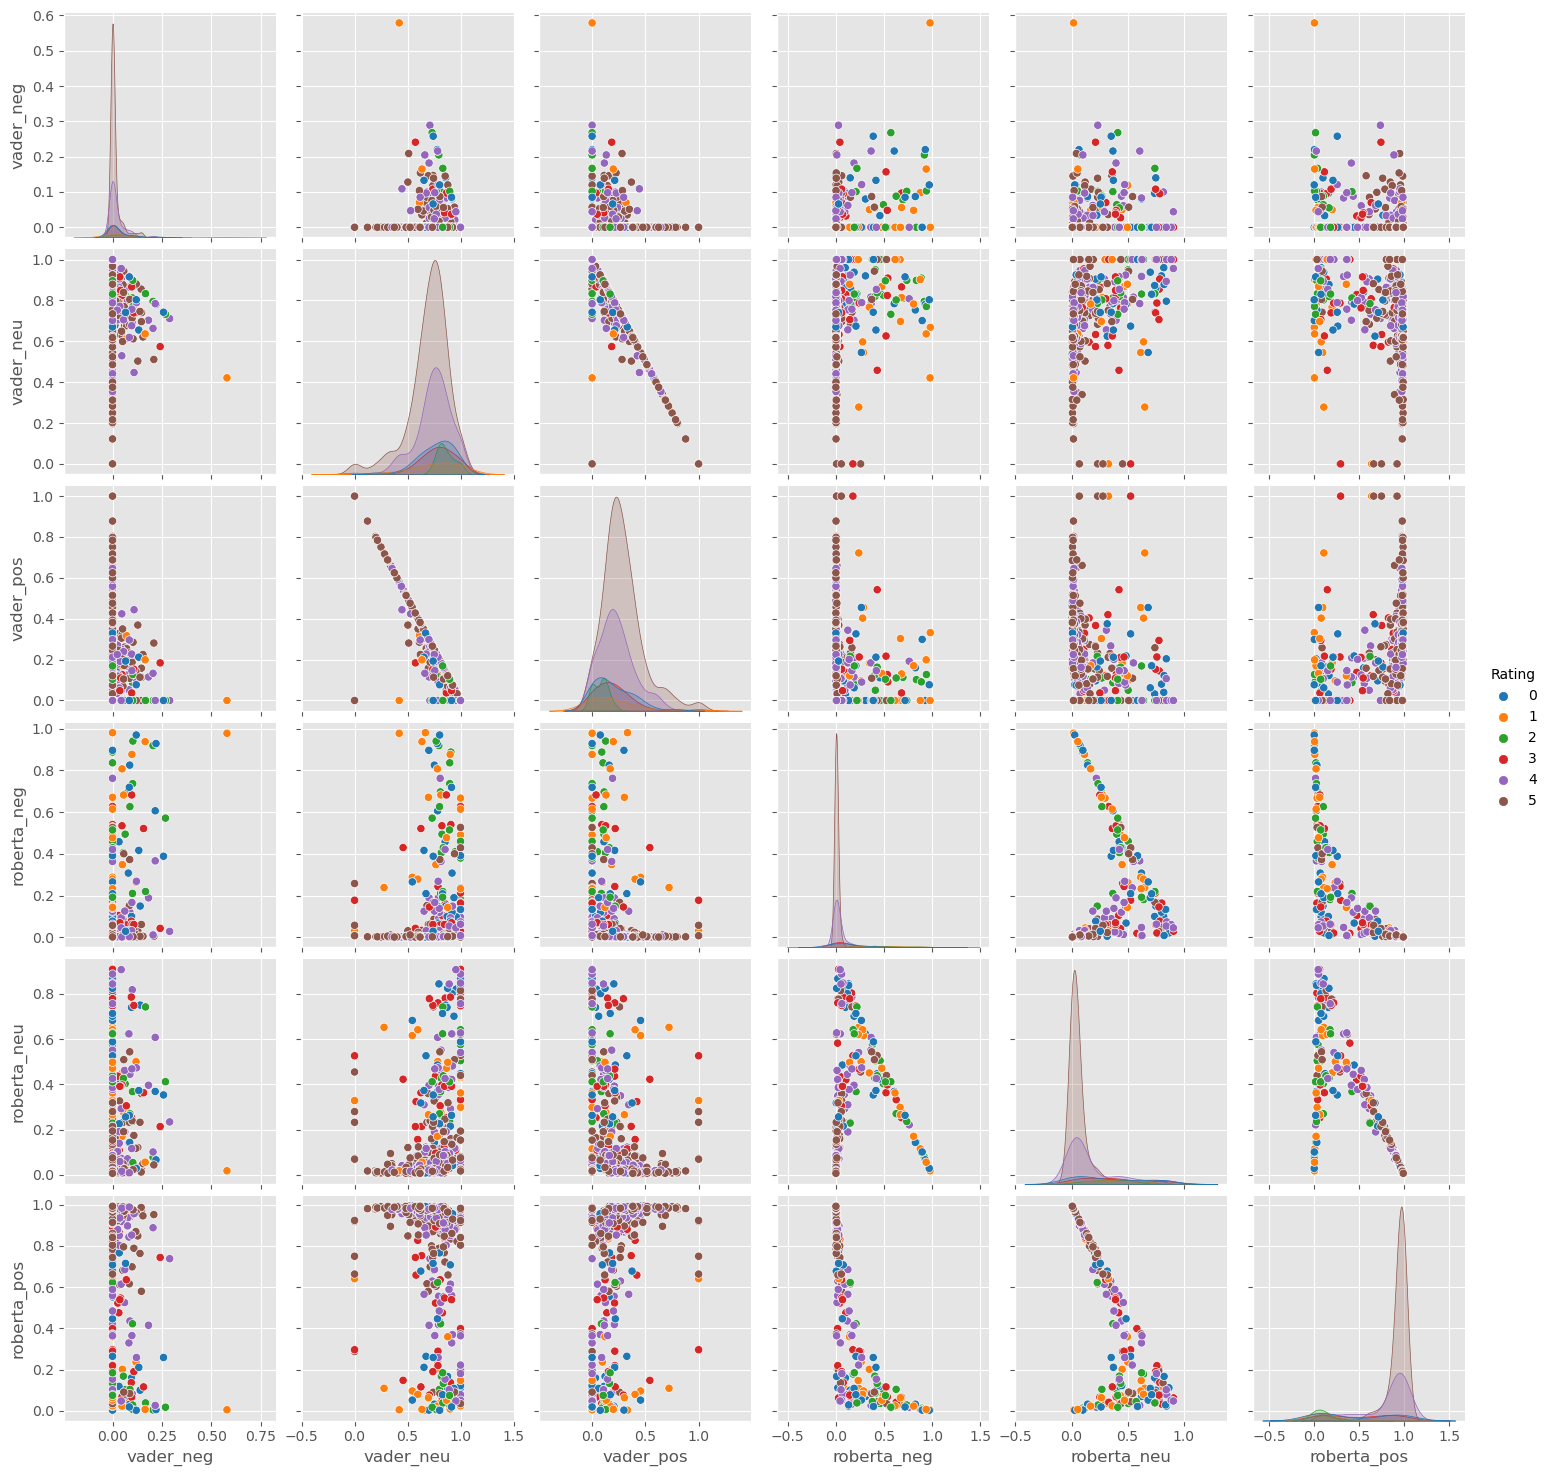

In [111]:
# create pairwise plots for each variable against another

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.pairplot(data = sentiment_df, 
             vars = ['vader_neg', 'vader_neu', 'vader_pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue = 'Rating', # different colours represent different ratings
             palette = 'tab10' # ten distinct colours to distinguish between different levels of hue for readability
            ) 
plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

## 7.2 Pairwise Plot Observations

If VADER and RoBERTa model were equally strong, we would expect that for any particular rating point, the VADER and RoBERTa scores are very similar or identical. However, the pairwise plots above show VADER being weaker than RoBERTa. The (roberta_pos, roberta_pos), (roberta_neu, roberta_neu), and (roberta_neg, roberta_neg) plots clearly show the roberta model being able to distinguish between positive, neutral, and negative sentiments since the positive sentiment distribution is way to the right, while the negative sentiment distribution is way to the left. Whereas, the (vader_pos, vader_pos), (vader_neu, vader_neu), and (vader_neg, vader_neg) plots have distributions in similar ranges for positive and neutral sentiments, showing the limitations of the VADER model.

It is clear that there are some reviews which the RoBERTa model can more accurately evaluate the sentiment of compared to the VADER model. Observe one extreme of (roberta_pos, vader_neg) which is the top-right plot. At the bottom-right of this plot, the purple point represents a rating of 4, meaning we would expect the review to overall have a positive sentiment. Since it is at the right of the x-axis, which is the RoBERTa score, it reflects that the RoBERTa model viewed this review as having positive sentiment, as expected. However, since it is at the bottom of the y-axis, which is the VADER score, it reflects that the VADER model viewed this review as having negative sentiment, which is unexpected. These observations make it clear that RoBERTa model is a more powerful model than the VADER model, since RoBERTa considers the relationships between words while VADER strictly assesses the words individually and independently.

## 7.3 Looking at the Extremes

In [112]:
# Positive VADER sentiment, review rating of 1

# look at the review for the most positive VADER score for a 1-star rating
sentiment_df.query('Rating == 1').sort_values('vader_pos', ascending = False)['Review'].values[0]

'I agree.'

In [113]:
# Negative VADER sentiment, review rating of 5

# look at the review for the most negative VADER score for a 5-star rating
sentiment_df.query('Rating == 5').sort_values('vader_neg', ascending = True)['Review'].values[0]

'better than any you can get at a restaurant!'

In [114]:
# Positive RoBERTa sentiment, review rating of 1

# look at the review for the most positive RoBERTa score for a 1-star rating
sentiment_df.query('Rating == 1').sort_values('roberta_pos', ascending = False)['Review'].values[0]

"It was pretty easy to make.  Another suggestion instead of nuts is frozen toffee.  It doesn't bake all the way, and is absolutely delicious!"

In [115]:
# Negative RoBERTa sentiment, review rating of 5

# look at the review for the most negative RoBERTa score for a 5-star rating
sentiment_df.query('Rating == 5').sort_values('roberta_neg', ascending = True)['Review'].values[0]

"I thought this recipe was very quick and easy and delicious. I made at Thanksgiving for my family and they really enjoyed it.  I'm making it again for some friends at work."